In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
file1 = '../seafood_data_junho/고등어.csv'
file2 = '../seafood_data_junho/고등어2022.csv'

In [4]:
file1 = pd.read_csv(file1)
file2 = pd.read_csv(file2)

In [5]:
df1 = pd.DataFrame(file1)
df2 = pd.DataFrame(file2)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9894 entries, 0 to 9893
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      9894 non-null   object 
 1   어종      9894 non-null   object 
 2   산지      9894 non-null   object 
 3   규격      9894 non-null   object 
 4   포장      9894 non-null   object 
 5   수량      9894 non-null   object 
 6   중량      9894 non-null   float64
 7   평균가     9894 non-null   object 
dtypes: float64(1), object(7)
memory usage: 618.5+ KB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      505 non-null    object 
 1   어종      505 non-null    object 
 2   산지      505 non-null    object 
 3   규격      505 non-null    object 
 4   포장      505 non-null    object 
 5   수량      505 non-null    object 
 6   중량      505 non-null    float64
 7   평균가     505 non-null    object 
dtypes: float64(1), object(7)
memory usage: 31.7+ KB


In [8]:
df = pd.concat([df1, df2], axis=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10399 entries, 0 to 504
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      10399 non-null  object 
 1   어종      10399 non-null  object 
 2   산지      10399 non-null  object 
 3   규격      10399 non-null  object 
 4   포장      10399 non-null  object 
 5   수량      10399 non-null  object 
 6   중량      10399 non-null  float64
 7   평균가     10399 non-null  object 
dtypes: float64(1), object(7)
memory usage: 731.2+ KB


In [10]:
df.columns

Index(['날짜', '어종', '산지', '규격', '포장', '수량', '중량', '평균가'], dtype='object')

In [11]:
df.columns = ['date', 'species', 'origin', 'standard', 'unit', 'amount', 'weight', 'avg_price']

In [12]:
# df = df.drop('unit', axis=1)

In [13]:
df.describe()

,weight
count,10399.000000
mean,13.744187
std,4.697785
min,1.000000
25%,10.000000
50%,15.000000
75%,15.000000
max,200.000000


## 데이터타입 변환

### 평균가에 , 기호 없애기

In [14]:
df['avg_price'] = df.avg_price.str.replace(',', '').astype('int')

### 수량에 , 기호 없애기

In [15]:
df['amount'] = df.amount.str.replace(',', '').astype('int')

In [16]:
df.dtypes

date          object
species       object
origin        object
standard      object
unit          object
amount         int32
weight       float64
avg_price      int32
dtype: object

### 날짜 데이터 년, 월, 일로 나누고 int형으로 변환

In [17]:
df['yyyy'], df['mm'], df['dd'] = df['date'].str.split('-').str

In [18]:
df.head()

,date,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
0,2017-01-02,(냉)고등어,노르웨이,중,S/P,6,10.0,62500,2017,01,02
1,2017-01-02,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,01,02
2,2017-01-02,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,01,02
3,2017-01-02,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,01,02
4,2017-01-02,(선)고등어,부산(기장),22미,S/P,2,15.0,10000,2017,01,02


In [19]:
df = df.drop('date', axis=1)

In [20]:
for i in ['yyyy', 'mm', 'dd']:
  df[i] = list(map(int, df[i]))

In [21]:
df.dtypes

species       object
origin        object
standard      object
unit          object
amount         int32
weight       float64
avg_price      int32
yyyy           int64
mm             int64
dd             int64
dtype: object

#### 년 / 월 / 일 별 가격변동

<AxesSubplot:xlabel='dd'>

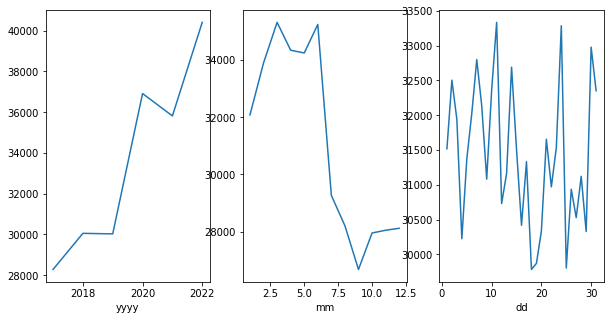

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(131)
Years = df.groupby('yyyy').mean()
Years['avg_price'].plot(x=df.yyyy)
plt.subplot(132)
Months = df.groupby('mm').mean()
Months['avg_price'].plot(x=df.mm)
plt.subplot(133)
Days = df.groupby('dd').mean()
Days['avg_price'].plot(x=df.dd)

#### 산지별 가격분포

Text(0, 0.5, 'origin')

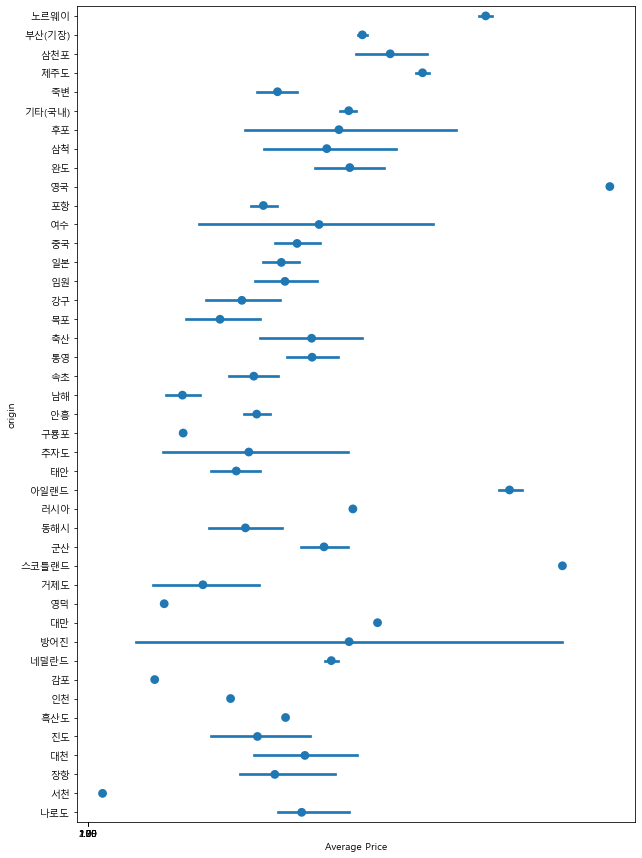

In [23]:
plt.rcParams['font.family']= 'Malgun Gothic'

plt.figure(figsize=(10, 15))
sns.pointplot(x='avg_price', y='origin', data=df, join=False)
plt.xticks(np.linspace(1, 2, 5))
plt.xlabel('Average Price')
plt.ylabel('origin')

In [24]:
gd_pdf = df[df.species=='(선)고등어']

In [25]:
gd_pdf.head()

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
1,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,1,2
2,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,1,2
3,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,1,2
4,(선)고등어,부산(기장),22미,S/P,2,15.0,10000,2017,1,2
5,(선)고등어,부산(기장),24미,S/P,48,15.0,27500,2017,1,2


In [26]:
gd_pdf['origin'].count()

6093

In [27]:
gd_pdf['origin'].value_counts()

부산(기장)    2937
제주도       2007
포항         188
안흥         167
삼천포        115
죽변          81
통영          81
군산          77
속초          61
일본          47
태안          43
완도          39
축산          34
임원          34
목포          33
남해          31
동해시         19
삼척          17
대천          15
강구          14
후포          10
추자도          8
거제도          6
진도           6
나로도          5
여수           4
기타(국내)       3
장항           3
방어진          2
구룡포          1
영덕           1
감포           1
인천           1
흑산도          1
서천           1
Name: origin, dtype: int64

### 100 이상을 차지하는 부산(기장), 제주도, 포항, 안흥, 삼천포만을 두고 제외하기

In [28]:
origin_mask = (gd_pdf.origin == '부산(기장)')|(gd_pdf.origin == '제주도')|(gd_pdf.origin == '포항')|(gd_pdf.origin == '안흥')|(gd_pdf.origin == '삼천포')


gd_pdf = gd_pdf.loc[origin_mask, :]

In [29]:
gd_pdf['origin'].value_counts()

부산(기장)    2937
제주도       2007
포항         188
안흥         167
삼천포        115
Name: origin, dtype: int64

In [30]:
gd_pdf['standard'].value_counts()

20미       721
중         614
18미       428
28미       371
24미       351
26미       324
12미       309
22미       293
15미       266
30미       239
10미       201
14미       171
35미       156
16미       156
13미        87
32미        85
대          72
40미        68
34미        63
8미         55
38미        48
17미        42
11미        38
25미        36
소          31
21미        23
9미         19
19미        16
바라         15
36미        15
6미         14
7미         12
23미        11
48미        10
42미         7
33미         7
파치          6
특대          5
27미         4
46미         4
4미          3
37미         3
5미          3
1미          1
13/14미      1
19/20미      1
12/15       1
11/12미      1
10/12       1
3미          1
29미         1
12/13미      1
45미         1
47미         1
44미         1
Name: standard, dtype: int64

In [31]:
gd_pdf[gd_pdf.standard=='중']

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
12,(선)고등어,부산(기장),중,S/P,3,10.0,45000,2017,1,2
15,(선)고등어,제주도,중,S/P,6,13.0,20800,2017,1,2
25,(선)고등어,부산(기장),중,S/P,1,15.0,5000,2017,1,3
26,(선)고등어,제주도,중,S/P,14,13.0,20100,2017,1,3
35,(선)고등어,부산(기장),중,S/P,140,15.0,13000,2017,1,4
...,...,...,...,...,...,...,...,...,...,...
101,(선)고등어,제주도,중,S/P,1,10.0,18000,2022,2,14
108,(선)고등어,제주도,중,S/P,39,15.0,26000,2022,2,15
115,(선)고등어,제주도,중,S/P,24,15.0,19800,2022,2,16
155,(선)고등어,제주도,중,S/P,2,10.0,13000,2022,3,1


In [32]:
standard_mask = (gd_pdf.standard == '20미')|(gd_pdf.standard == '중')|(gd_pdf.standard == '18미')|(gd_pdf.standard == '28미')


gd_pdf = gd_pdf.loc[standard_mask, :]

In [33]:
gd_pdf['standard'].value_counts()

20미    721
중      614
18미    428
28미    371
Name: standard, dtype: int64

#### 추려낸 위 규격에서 가장 많은 포장을 차지하는 S/P포장으로 단일화

In [34]:
gd_pdf['unit'].value_counts()

S/P        2087
c/s(상자)      32
kg           11
box           3
CT/(BT)       1
Name: unit, dtype: int64

In [35]:
gd_pdf = gd_pdf[gd_pdf.unit=='S/P']

In [37]:
gd_pdf.head(3)

,species,origin,standard,unit,amount,weight,avg_price,yyyy,mm,dd
1,(선)고등어,부산(기장),20미,S/P,3,10.0,40000,2017,1,2
2,(선)고등어,부산(기장),20미,S/P,652,15.0,31800,2017,1,2
3,(선)고등어,부산(기장),20미,S/P,70,20.0,45000,2017,1,2


In [38]:
gd_pdf = gd_pdf.drop(['species', 'unit'], axis=1)

gd_pdf.head()

,origin,standard,amount,weight,avg_price,yyyy,mm,dd
1,부산(기장),20미,3,10.0,40000,2017,1,2
2,부산(기장),20미,652,15.0,31800,2017,1,2
3,부산(기장),20미,70,20.0,45000,2017,1,2
7,부산(기장),28미,71,15.0,10000,2017,1,2
8,부산(기장),28미,80,20.0,14000,2017,1,2


### 범주형 데이터 OHE 수행

In [39]:
gd_pdf = pd.get_dummies(gd_pdf, columns=['origin', 'standard'])

In [40]:
gd_pdf.head(3)

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
1,3,10.0,40000,2017,1,2,1,0,0,0,0,0,1,0,0
2,652,15.0,31800,2017,1,2,1,0,0,0,0,0,1,0,0
3,70,20.0,45000,2017,1,2,1,0,0,0,0,0,1,0,0


In [41]:
gd_pdf.to_csv('cleaned_gd.csv')

In [38]:
gd_pdf.describe()

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,163.249161,14.653570,36605.654049,2018.254911,6.601342,15.718735,0.577384,0.026354,0.011979,0.339722,0.044562,0.204121,0.343076,0.177288,0.275515
std,287.890553,4.178113,18822.833145,1.282373,3.391823,8.635583,0.494094,0.160223,0.108817,0.473728,0.206389,0.403154,0.474850,0.382004,0.446881
min,1.000000,1.000000,2000.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,13.000000,22000.000000,2017.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,15.000000,34900.000000,2018.000000,7.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,171.000000,15.000000,49550.000000,2019.000000,9.000000,23.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2586.000000,143.000000,120000.000000,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 시각화

In [39]:
num_cols = ['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd']
num_gd_pdf = gd_pdf[num_cols]

<AxesSubplot:>

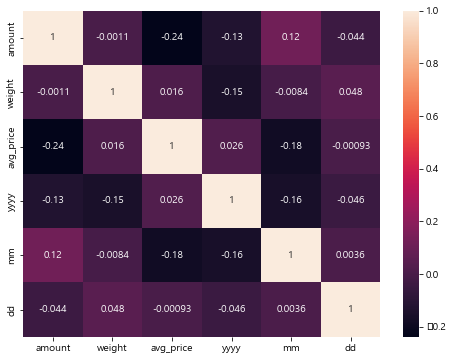

In [40]:
plt.figure(figsize=(8, 6))
sns.heatmap(num_gd_pdf.corr(), annot=True)

In [41]:
print(gd_pdf.columns)
print("컬럼 수 :", len(gd_pdf.columns))

Index(['amount', 'weight', 'avg_price', 'yyyy', 'mm', 'dd', 'origin_부산(기장)',
       'origin_삼천포', 'origin_안흥', 'origin_제주도', 'origin_포항', 'standard_18미',
       'standard_20미', 'standard_28미', 'standard_중'],
      dtype='object')
컬럼 수 : 15


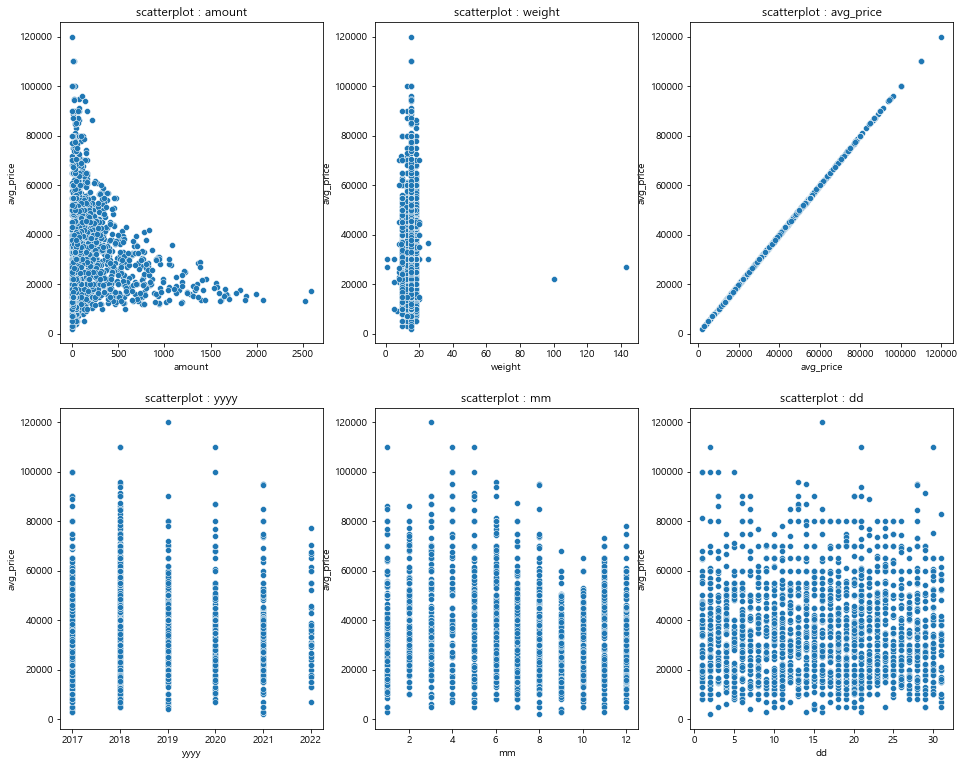

In [42]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_gd_pdf.columns)):
    sns.scatterplot(data = num_gd_pdf, y = 'avg_price' ,x = num_gd_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_gd_pdf.columns[i])

plt.show()

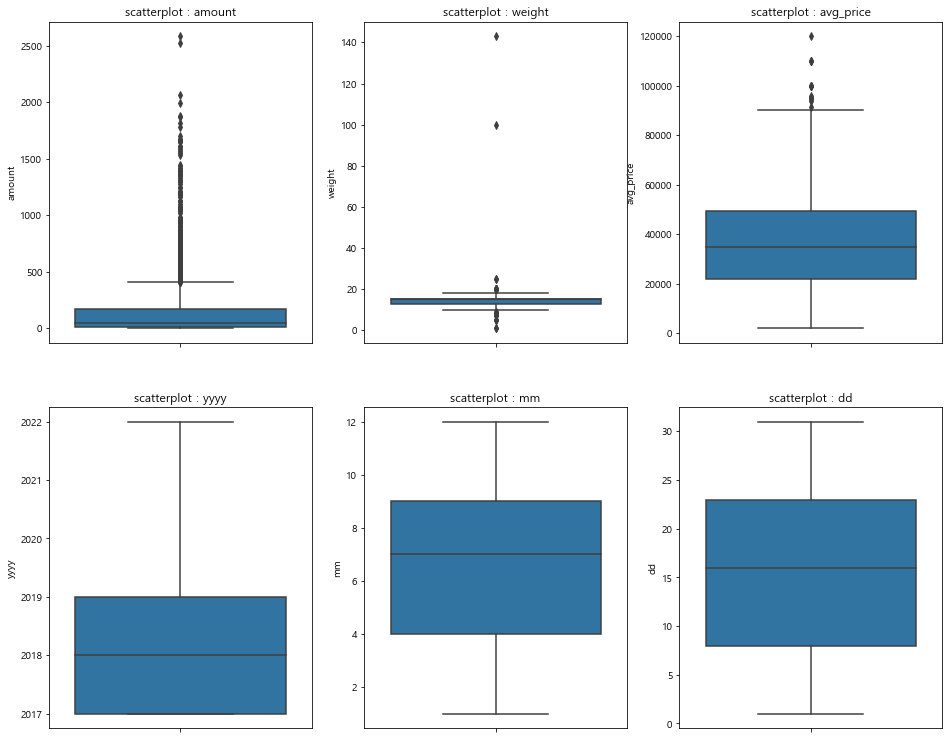

In [43]:
fig, ax = plt.subplots(nrows = 2, ncols =3)
fig.set_size_inches(16,13)
for i in range(len(num_gd_pdf.columns)):
    sns.boxplot(data = num_gd_pdf, y = num_gd_pdf.columns[i], ax= ax[int(i//3)][int(i%3)])
    ax[int(i//3)][int(i%3)].set_title("scatterplot : " + num_gd_pdf.columns[i])

plt.show()

### 결측치 제거

amout > 2500 이상 데이터 제거

In [44]:
gd_pdf['amount'].sort_values()

1976       1
7457       1
7455       1
3943       1
7398       1
        ... 
5546    1881
6409    1996
5312    2064
5521    2526
6536    2586
Name: amount, Length: 2087, dtype: int32

In [45]:
gd_pdf = gd_pdf[gd_pdf.amount < 2500]

weight > 100 이상 데이터 제거

In [46]:
gd_pdf['weight'].sort_values()

6298      1.0
4008      1.0
1089      5.0
8111      5.0
7412      5.0
        ...  
6806     20.0
4694     25.0
4693     25.0
2051    100.0
4056    143.0
Name: weight, Length: 2085, dtype: float64

In [47]:
gd_pdf = gd_pdf[gd_pdf.weight < 100]

avg_price >  이상 데이터 제거 => 안하기로

In [48]:
gd_pdf['avg_price'].sort_values()

9550      2000
200       3000
9804      3000
9701      3000
2267      3000
         ...  
1071    100000
4405    110000
7520    110000
4536    110000
6719    120000
Name: avg_price, Length: 2083, dtype: int32

In [76]:
gd_pdf = gd_pdf[gd_pdf.avg_price <= 100000]

In [77]:
gd_pdf.count()

amount           2079
weight           2079
avg_price        2079
yyyy             2079
mm               2079
dd               2079
origin_부산(기장)    2079
origin_삼천포       2079
origin_안흥        2079
origin_제주도       2079
origin_포항        2079
standard_18미     2079
standard_20미     2079
standard_28미     2079
standard_중       2079
dtype: int64

## 선형 회귀

In [78]:
gd_pdf.head()

,amount,weight,avg_price,yyyy,mm,dd,origin_부산(기장),origin_삼천포,origin_안흥,origin_제주도,origin_포항,standard_18미,standard_20미,standard_28미,standard_중
1,3,10.0,40000,2017,1,2,1,0,0,0,0,0,1,0,0
2,652,15.0,31800,2017,1,2,1,0,0,0,0,0,1,0,0
3,70,20.0,45000,2017,1,2,1,0,0,0,0,0,1,0,0
7,71,15.0,10000,2017,1,2,1,0,0,0,0,0,0,1,0
8,80,20.0,14000,2017,1,2,1,0,0,0,0,0,0,1,0


In [79]:
X = gd_pdf.drop(columns='avg_price')
y = gd_pdf['avg_price']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20, shuffle =True, test_size = 0.2)

In [81]:
gd_model_lr = LinearRegression()
gd_model_lr.fit(X_train, y_train)
gd_lr_y_pred = gd_model_lr.predict(X_test)

In [82]:
print(gd_model_lr.score(X_train, y_train))
print(gd_model_lr.score(X_test, y_test))

0.30087499753942915
0.23385145837348087


In [60]:
y_test = np.array(y_test)

In [61]:
MSE = mean_squared_error(y_test, gd_lr_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lr_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 250170031.36831, RMSE : 15816.76425
r2_score :  0.24043137881609022


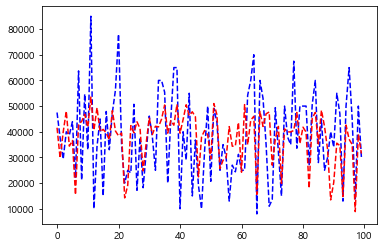

In [62]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_lr_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

In [63]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

minmax_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)

x_train_scaled = minmax_scaler.transform(X_train)
x_test_scaled = minmax_scaler.transform(X_test)

In [64]:
gd_model_lr.fit(x_train_scaled, y_train)
gd_y_pred_scaled = gd_model_lr.predict(x_test_scaled)

In [65]:
MSE = mean_squared_error(y_test, gd_y_pred_scaled)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_y_pred_scaled)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 250170031.36831, RMSE : 15816.76425
r2_score :  0.24043137881609045


## 랜덤포레스트

In [66]:
gd_model_rf = RandomForestRegressor()

gd_model_rf.fit(X_train, y_train)
gd_rf_y_pred = gd_model_rf.predict(X_test)

In [67]:
MSE = mean_squared_error(y_test, gd_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 157856523.07434, RMSE : 12564.09659
r2_score :  0.5207145279526342


In [68]:
rf_parameters = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 6, 9, 12],
    # 'max_depth': [5, 6, 9, 12],
    # 'min_samples_split': [0.01, 0.02, 0.1, 0.15],
    # 'max_features': ['auto', 'sqrt'],
    'random_state':[99]
}

cv = KFold(n_splits=6)

rf = RandomForestRegressor()
rf_grid_cv = GridSearchCV(rf, param_grid=rf_parameters, cv=cv, n_jobs=-1, scoring='r2')
rf_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', rf_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(rf_grid_cv.best_score_))

KeyboardInterrupt: 

In [70]:
gd_model_rf = rf_grid_cv.best_estimator_
gd_rf_y_pred = gd_model_rf.predict(X_test)

In [71]:
MSE = mean_squared_error(y_test, gd_rf_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_rf_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 141959849.28473, RMSE : 11914.69048
r2_score :  0.5693320850842345


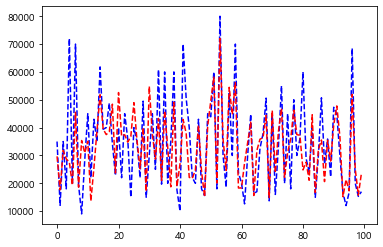

In [72]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_rf_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## XGBRegressor

In [69]:
gd_model_xgb = XGBRegressor()

gd_model_xgb.fit(X_train, y_train)
gd_xgb_y_pred = gd_model_xgb.predict(X_test)

In [70]:
MSE = mean_squared_error(y_test, gd_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 169256772.77894, RMSE : 13009.87213
r2_score :  0.4861009817100601


뭐지 스탠다드 스케일링 한 데이터 넣으니까 r2 개판됨

In [75]:
gd_model_xgb.fit(x_train_scaled, y_train)
gd_xgb_y_pred_scaled = gd_model_xgb.predict(X_test)

MSE = mean_squared_error(y_test, gd_xgb_y_pred_scaled)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred_scaled)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 344711227.80258, RMSE : 18566.40051
r2_score :  -0.04576094208181791


xgb에 gcv 해본 것

In [76]:
xg_parameters ={'max_depth' : [3,4,5,6] , 
                # 'n_estimators': [12,24,32], 
                'n_estimators': [100,200,300], 
                'learning_rate':[0.01, 0.1], 
                # 'learning_rate':[0.1, 0.3, 0.5], 
                'gamma': [1, 2, 4], 
                'random_state':[99]}

xgb = XGBRegressor()
xgb_grid_cv = GridSearchCV(xgb, param_grid=xg_parameters, cv=6, n_jobs=-1, scoring='r2')
xgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', xgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(xgb_grid_cv.best_score_))


최적 하이퍼 파라미터: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'random_state': 99}
최적 예측 정확도: 0.5308


In [77]:
gd_model_xgb = xgb_grid_cv.best_estimator_
gd_xgb_y_pred = gd_model_xgb.predict(X_test)

In [78]:
MSE = mean_squared_error(y_test, gd_xgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_xgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 153560834.61897, RMSE : 12391.96654
r2_score :  0.5341378228330539


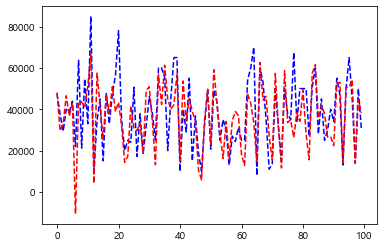

In [71]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_xgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()

## lightGBM

In [72]:
gd_model_lgb = LGBMRegressor()

gd_model_lgb.fit(X_train, y_train)
gd_lgb_y_pred = gd_model_lgb.predict(X_test)

In [73]:
MSE = mean_squared_error(y_test, gd_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 163225993.20275, RMSE : 12775.99285
r2_score :  0.5044116918390585


In [82]:
# lgb_parameters ={'max_depth' : [3,4,5,6] ,  
#                 'n_estimators': [100,300,500], 
#                 'learning_rate':[0.01, 0.05, 0.1],   
#                 'random_state':[99]}

lgb_parameters ={
    'n_estimators': [200, 500, 1000, 2000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [6, 7, 8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0] 
                }

lgb = LGBMRegressor()
lgb_grid_cv = GridSearchCV(lgb, param_grid=lgb_parameters, cv=6, n_jobs=-1, scoring='r2')
lgb_grid_cv.fit(X_train, y_train)
 
 
print('최적 하이퍼 파라미터:', lgb_grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(lgb_grid_cv.best_score_))

최적 하이퍼 파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
최적 예측 정확도: 0.5314


In [83]:
gd_model_lgb = lgb_grid_cv.best_estimator_
gd_lgb_y_pred = gd_model_lgb.predict(X_test)

In [84]:
MSE = mean_squared_error(y_test, gd_lgb_y_pred)
RMSE = np.sqrt(MSE)
r2 = r2_score(y_test, gd_lgb_y_pred)

print('MSE : {0:.5f}, RMSE : {1:.5f}'.format(MSE, RMSE))
print("r2_score : ", r2)

MSE : 147915838.47756, RMSE : 12162.06555
r2_score :  0.5512632194164995


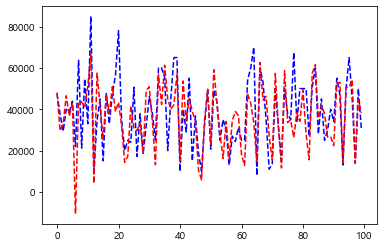

In [74]:
real = []
pred = []
index = []

for i in range(100):
  index.append(i)
  real.append(y_test[i])
  pred.append(gd_xgb_y_pred[i])
  
plt.plot(index, real, 'b--', label="Real")
plt.plot(index, pred, 'r--', label="Pred")
plt.show()